In [1]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
train_target = train_target[['EMB_MIC']]
# don't touch test data, split out validation data from training data during training
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
test_target = test_target[['EMB_MIC']]

all_data = np.concatenate((train_data, test_data), axis=0)
all_target = pd.concat((train_target, test_target), axis=0)

train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


## cornloss weighting

In [10]:
train_target_counts = torch.from_numpy(train_target.values).flatten()
# train_target_counts = torch.tensor([0,1,2])


In [11]:
import torch
import torch.nn.functional as F

def compute_class_weights(y_train, num_classes):
    class_counts = torch.bincount(y_train, minlength=num_classes)
    print(class_counts)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum() * num_classes  # Normalize weights
    return class_weights

# Example usage
num_classes = 3
class_weights = compute_class_weights(train_target_counts, num_classes)
print(class_weights)

tensor([6501, 1193, 1462])
tensor([0.2753, 1.5004, 1.2243])


In [5]:
def loss_corn(logits, y_train, num_classes, class_weights):
    sets = []
    for i in range(num_classes - 1):
        label_mask = y_train > i - 1
        label_tensor = (y_train[label_mask] > i).to(torch.int64)
        sets.append((label_mask, label_tensor))

    num_examples = 0
    losses = 0.
    for task_index, s in enumerate(sets):
        train_examples = s[0]
        train_labels = s[1]

        if len(train_labels) < 1:
            continue

        num_examples += len(train_labels)
        pred = logits[train_examples, task_index]

        # Apply class weights
        weights = class_weights[train_labels].to(logits.device)
        
        loss = -torch.sum(weights * (F.logsigmoid(pred) * train_labels +
                                     (F.logsigmoid(pred) - pred) * (1 - train_labels)))
        losses += loss
    return losses / num_examples

# Example usage
# logits = torch.randn(9, 2).cuda()  # Example logits tensor
# y_train = torch.tensor([0, 1, 2, 0, 1, 2, 2, 1, 0]).cuda()  # Example training labels
# class_weights = compute_class_weights(y_train.cpu(), num_classes).cuda()

# loss = loss_corn(logits, y_train, num_classes, class_weights)
# print(f"Loss: {loss.item()}")


## cornloss

In [ ]:
# def loss_corn(logits, y_train, num_classes):
#     sets = []
#     for i in range(num_classes-1):
#         label_mask = y_train > i-1
#         label_tensor = (y_train[label_mask] > i).to(torch.int64)
#         sets.append((label_mask, label_tensor))

#     num_examples = 0
#     losses = 0.
#     for task_index, s in enumerate(sets):
#         train_examples = s[0]
#         train_labels = s[1]

#         if len(train_labels) < 1:
#             continue

#         num_examples += len(train_labels)
#         pred = logits[train_examples, task_index]

#         loss = -torch.sum(F.logsigmoid(pred)*train_labels
#                           + (F.logsigmoid(pred) - pred)*(1-train_labels)
#                           )
#         losses += loss
#     return losses/num_examples


In [6]:

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%
def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

 


In [7]:
       
from torch.optim.lr_scheduler import CyclicLR

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=2,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [54336]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        x = self.prediction_layer(x)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

## Single run

In [9]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0.05
dense_dropout_rate=0.5
weight_decay=1e-8
######################################

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn


# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = loss_corn(pred, y_batch, 3, class_weights)
        print(pred)
        print(y_batch)
        print(loss_train)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate
        break
    break
    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")

NameError: name 'Model' is not defined

## Hypterparameter tuning

lr: 0.0001 epoch: 250 conv_dropout_rate: 0.05 dense_dropout_rate: 0.1 weight_decay: 1e-08


 20%|██        | 50/250 [03:28<20:39,  6.20s/it]

Epoch 50
Training loss: 0.22952815890312195
Validation loss: 0.2528999447822571


 40%|████      | 100/250 [05:51<07:12,  2.89s/it]

Epoch 100
Training loss: 0.22669292986392975
Validation loss: 0.2537498474121094


 60%|██████    | 150/250 [08:17<04:52,  2.93s/it]

Epoch 150
Training loss: 0.2247113138437271
Validation loss: 0.25428447127342224


 80%|████████  | 200/250 [12:04<02:47,  3.34s/it]

Epoch 200
Training loss: 0.2234937846660614
Validation loss: 0.2522830665111542


100%|██████████| 250/250 [14:46<00:00,  3.55s/it]

Epoch 250
Training loss: 0.22384914755821228
Validation loss: 0.254440039396286


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb


/tmp/ipykernel_12140/649166364.py:170: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-08
)
Learning rate: 0.0001
Weight decay: 1e-08
Accuracy: 0.09436435124508519
Mae: 1.215814766273482
F1 Score: 0.10960672828425745
conf_matrix: [[ 159 1034  432]
 [ 227   53   19]
 [ 278   83    4]]
lr: 0.0001 epoch: 250 conv_dropout_rate: 0.05 dense_dropout_rate: 0.2 weight_decay: 1e-08


 20%|██        | 50/250 [02:42<10:44,  3.22s/it]

Epoch 50
Training loss: 0.23123016953468323
Validation loss: 0.25475358963012695


 40%|████      | 100/250 [05:23<08:05,  3.23s/it]

Epoch 100
Training loss: 0.2281034141778946
Validation loss: 0.25611430406570435


 60%|██████    | 150/250 [08:59<10:49,  6.49s/it]

Epoch 150
Training loss: 0.22622433304786682
Validation loss: 0.2523583173751831


 80%|████████  | 200/250 [11:56<02:42,  3.25s/it]

Epoch 200
Training loss: 0.22572404146194458
Validation loss: 0.25406312942504883


100%|██████████| 250/250 [14:38<00:00,  3.51s/it]

Epoch 250
Training loss: 0.22459815442562103
Validation loss: 0.25453823804855347


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb


/tmp/ipykernel_12140/649166364.py:170: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-08
)
Learning rate: 0.0001
Weight decay: 1e-08
Accuracy: 0.1363040629095675
Mae: 1.1498470948012232
F1 Score: 0.1634799940370335
conf_matrix: [[262 998 365]
 [238  49  12]
 [290  74   1]]
lr: 0.0001 epoch: 250 conv_dropout_rate: 0.05 dense_dropout_rate: 0.3 weight_decay: 1e-08


 20%|██        | 50/250 [03:15<20:19,  6.10s/it]

Epoch 50
Training loss: 0.23121225833892822
Validation loss: 0.25343242287635803


 40%|████      | 100/250 [06:02<06:57,  2.78s/it]

Epoch 100
Training loss: 0.22822318971157074
Validation loss: 0.25323501229286194


 60%|██████    | 150/250 [09:13<07:16,  4.36s/it]

Epoch 150
Training loss: 0.22750116884708405
Validation loss: 0.25322479009628296


 80%|████████  | 200/250 [11:49<02:20,  2.81s/it]

Epoch 200
Training loss: 0.2261972576379776
Validation loss: 0.2569817900657654


100%|██████████| 250/250 [14:22<00:00,  3.45s/it]

Epoch 250
Training loss: 0.22613568603992462
Validation loss: 0.2546449303627014


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb


/tmp/ipykernel_12140/649166364.py:170: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-08
)
Learning rate: 0.0001
Weight decay: 1e-08
Accuracy: 0.145041502839668
Mae: 0.981651376146789
F1 Score: 0.17020218942838442
conf_matrix: [[ 277 1338   10]
 [ 244   55    0]
 [ 280   85    0]]
lr: 0.0001 epoch: 250 conv_dropout_rate: 0.05 dense_dropout_rate: 0.4 weight_decay: 1e-08


 20%|██        | 50/250 [04:56<13:31,  4.06s/it]

Epoch 50
Training loss: 0.23463702201843262
Validation loss: 0.25635331869125366


 40%|████      | 100/250 [08:10<10:51,  4.34s/it]

Epoch 100
Training loss: 0.2305869311094284
Validation loss: 0.25174614787101746


 60%|██████    | 150/250 [11:43<06:54,  4.14s/it]

Epoch 150
Training loss: 0.22899939119815826
Validation loss: 0.24968883395195007


 80%|████████  | 200/250 [15:18<03:32,  4.25s/it]

Epoch 200
Training loss: 0.22802549600601196
Validation loss: 0.25271135568618774


100%|██████████| 250/250 [20:20<00:00,  4.88s/it]

Epoch 250
Training loss: 0.22713279724121094
Validation loss: 0.251889705657959


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb


/tmp/ipykernel_12140/649166364.py:170: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-08
)
Learning rate: 0.0001
Weight decay: 1e-08
Accuracy: 0.07208387942332896
Mae: 1.1480996068152032
F1 Score: 0.07805358828615695
conf_matrix: [[ 105 1290  230]
 [ 228   54   17]
 [ 274   85    6]]
lr: 0.0001 epoch: 250 conv_dropout_rate: 0.05 dense_dropout_rate: 0.5 weight_decay: 1e-08


 20%|██        | 50/250 [03:40<17:54,  5.37s/it]

Epoch 50
Training loss: 0.23714382946491241
Validation loss: 0.25503700971603394


 40%|████      | 100/250 [08:42<14:58,  5.99s/it]

Epoch 100
Training loss: 0.23140406608581543
Validation loss: 0.2540320158004761


 60%|██████    | 150/250 [12:29<07:22,  4.43s/it]

Epoch 150
Training loss: 0.2283726930618286
Validation loss: 0.256374716758728


 80%|████████  | 200/250 [16:04<03:42,  4.46s/it]

Epoch 200
Training loss: 0.22831326723098755
Validation loss: 0.25502365827560425


100%|██████████| 250/250 [19:41<00:00,  4.73s/it]

Epoch 250
Training loss: 0.22765222191810608
Validation loss: 0.2522863745689392


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb


/tmp/ipykernel_12140/649166364.py:170: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-08
)
Learning rate: 0.0001
Weight decay: 1e-08
Accuracy: 0.11009174311926606
Mae: 1.0620358235037135
F1 Score: 0.1272059762473309
conf_matrix: [[ 187 1305  133]
 [ 232   60    7]
 [ 261   99    5]]


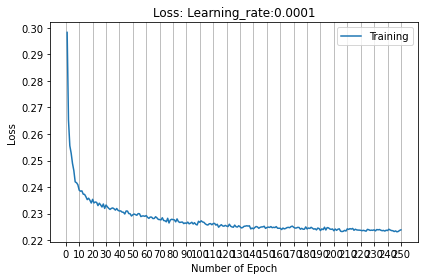

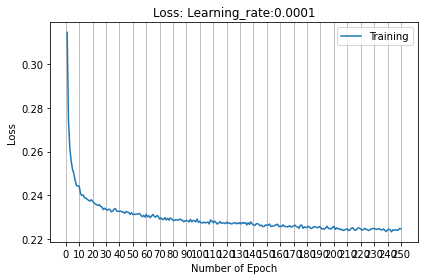

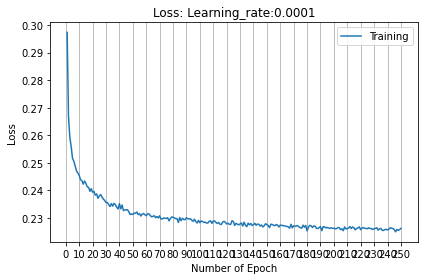

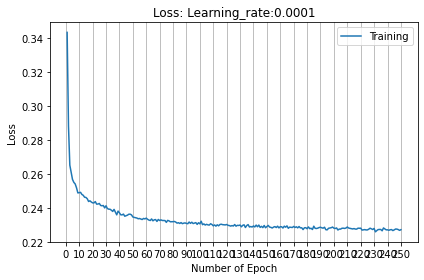

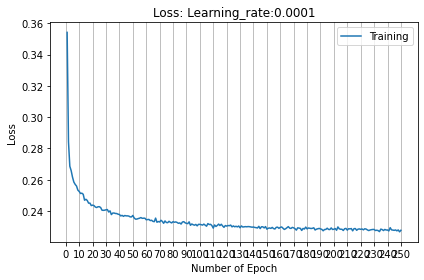

In [12]:
for dr in [0.1, 0.2, 0.3, 0.4, 0.5]:

    #input parameter
    lr = 0.0001
    epoch = 250
    conv_dropout_rate=0.05
    dense_dropout_rate=dr
    weight_decay=1e-8
    
    print("="*20)
    print("lr:", lr, "epoch:", epoch, "conv_dropout_rate:", conv_dropout_rate, "dense_dropout_rate:", dense_dropout_rate, "weight_decay:", weight_decay)
    print("="*20)
    ######################################

    model = Model(
    num_classes=3,
    num_filters=64,
    num_conv_layers=2,
    # num_dense_neurons=256, # batch_size = 64
    num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=False,
    conv_dropout_rate=conv_dropout_rate,
    dense_dropout_rate=dense_dropout_rate
    ).to(device)

    # model = Model( #! way too memory intensive
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64

    # num_dense_layers=2,
    # return_logits=True,
    # conv_dropout_rate=0,
    # dense_dropout_rate=0
    # ).to(device)
    ## early stopping
    best_val_loss = float('inf')
    patience = 8  # How many epochs to wait after last time validation loss improved.
    patience_counter = 0
    lmbda = torch.tensor(1e-4, dtype = torch.float32)

    batch_size = 128
    # lr = 0.0085
    # lr = 0.00002
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

    # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
    # test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
    # criterion = nn.MSELoss()
    # criterion = masked_weighted_MAE
    # criterion = masked_weighted_MSE
    # criterion = weighted_cross_entropy_loss_fn


    # criterion = masked_MAE

    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
    # scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
    #%%

    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()

    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch = y_train.to(device)
            x_batch = x_batch.float()
            pred = model(x_batch.float())

            # break
            loss_train = loss_corn(pred, y_batch, 3, class_weights)

            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # scheduler.step()  # Update the learning rate

        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                y_batch = y_test.to(device)
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())

                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                loss_test = loss_corn(pred, y_batch, 3, class_weights)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

        if e % 50 == 0:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
        # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
        # print(train_batch_loss)
        # print(test_batch_loss)
        # print(f"Training loss: {np.mean(train_batch_loss)}")
        # print(f"Validation loss: {np.mean(test_batch_loss)}")
        # #! implementing early stopping
        # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
        # print(f'Current val loss: {current_val_loss}')
        # print(f'Best val loss: {best_val_loss}')
        # if current_val_loss < best_val_loss:
        #     best_val_loss = current_val_loss
        #     patience_counter = 0  # reset patience counter
        #     # Save the best model
        #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print("Early stopping triggered")
        #         torch.save({
        #         'optimizer': optimizer.state_dict(),
        #         'model': model.state_dict(),
        #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
        #         break  # Early stopping
            
    print('==='*10)
    # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
    save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
                train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
    print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

    #%%
    testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

    model.eval()  # For inference

    ic.disable()
    model.eval()
    pred_list = []
    target_list  = []
    mse_list = []
    with torch.no_grad():
        for x_test, y_test in testing_loader1:
            xtest1 = x_test.to(device).float()
            ytest1 = y_test.to(device).float()
            pred = model(xtest1)
            pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
            target_list.append(y_test.detach().cpu().numpy())
    target_list = np.array(target_list).flatten()


    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

    def calculate_metrics(true_labels, predictions):
        """
        Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

        Parameters:
        - true_labels: List or array of true labels
        - predictions: List or array of predicted labels

        Returns:
        - accuracy: Overall accuracy of predictions
        - f1: Weighted average F1 score
        - conf_matrix: Multiclass confusion matrix
        - mae: Mean Absolute Error of predictions
        """
        # Ensure inputs are numpy arrays for consistency
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Calculate F1 score
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)

        # Calculate MAE
        mae = mean_absolute_error(true_labels, predictions)

        return accuracy, f1, conf_matrix, mae

    # Example usage
    # true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
    # predictions = [0, 2, 2, 1, 0, 0, 1, 0]

    accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

    print("======================")
    print("Model's Named Parameters:")
    # for name, param in model.named_parameters():
    #     print(f"Name: {name}")
    #     print(f"Shape: {param.size()}")
    #     print(f"Requires grad: {param.requires_grad}")
    #     print('-----')
    print("Optimizer details:")
    print(optimizer)
    for param_group in optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
        print("Weight decay:", param_group.get('weight_decay', 'Not set'))
        
    print("======================")
    print(f"Accuracy: {accuracy}")
    print(f"Mae: {mae}")
    print(f"F1 Score: {f1}")
    print(f"conf_matrix: {conf_matrix}")
    print("======================")

## One cycle lr

In [21]:
len(train_loader)

64

  0%|          | 0/250 [00:00<?, ?it/s]/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 1/250 [00:02<11:40,  2.82s/it]

Epoch 1
Training loss: 0.7334721684455872
Validation loss: 0.7043706178665161


  1%|          | 2/250 [00:05<11:35,  2.80s/it]

Epoch 2
Training loss: 0.7267924547195435
Validation loss: 0.7308678030967712


  1%|          | 3/250 [00:08<11:56,  2.90s/it]

Epoch 3
Training loss: 0.7224966883659363
Validation loss: 0.7300105690956116


  2%|▏         | 4/250 [00:11<11:51,  2.89s/it]

Epoch 4
Training loss: 0.7184432148933411
Validation loss: 0.7219763398170471


  2%|▏         | 5/250 [00:14<11:44,  2.88s/it]

Epoch 5
Training loss: 0.7110683917999268
Validation loss: 0.7187599539756775


  2%|▏         | 6/250 [00:17<11:36,  2.85s/it]

Epoch 6
Training loss: 0.706829309463501
Validation loss: 0.7193397879600525


  3%|▎         | 7/250 [00:19<11:28,  2.84s/it]

Epoch 7
Training loss: 0.7022131681442261
Validation loss: 0.7104915976524353


  3%|▎         | 8/250 [00:22<11:22,  2.82s/it]

Epoch 8
Training loss: 0.6977000832557678
Validation loss: 0.7093948125839233


  4%|▎         | 9/250 [00:25<11:38,  2.90s/it]

Epoch 9
Training loss: 0.6939187049865723
Validation loss: 0.7058728933334351


  4%|▍         | 10/250 [00:28<11:32,  2.89s/it]

Epoch 10
Training loss: 0.6895869970321655
Validation loss: 0.699689507484436


  4%|▍         | 11/250 [00:31<11:25,  2.87s/it]

Epoch 11
Training loss: 0.6865582466125488
Validation loss: 0.6964080333709717


  5%|▍         | 12/250 [00:34<11:19,  2.85s/it]

Epoch 12
Training loss: 0.6826993227005005
Validation loss: 0.6952136754989624


  5%|▌         | 13/250 [00:37<11:16,  2.85s/it]

Epoch 13
Training loss: 0.679500162601471
Validation loss: 0.6918784976005554


  6%|▌         | 14/250 [00:40<11:15,  2.86s/it]

Epoch 14
Training loss: 0.676413357257843
Validation loss: 0.6912794709205627


  6%|▌         | 15/250 [00:43<11:27,  2.93s/it]

Epoch 15
Training loss: 0.6753220558166504
Validation loss: 0.6890814304351807


  6%|▋         | 16/250 [00:45<11:15,  2.89s/it]

Epoch 16
Training loss: 0.6737663745880127
Validation loss: 0.6851076483726501


  7%|▋         | 17/250 [00:48<10:54,  2.81s/it]

Epoch 17
Training loss: 0.6703720092773438
Validation loss: 0.6842448711395264


  7%|▋         | 18/250 [00:51<10:41,  2.77s/it]

Epoch 18
Training loss: 0.6681638956069946
Validation loss: 0.6822130680084229


  8%|▊         | 19/250 [00:53<10:30,  2.73s/it]

Epoch 19
Training loss: 0.6659942269325256
Validation loss: 0.6812692880630493


  8%|▊         | 20/250 [00:56<10:21,  2.70s/it]

Epoch 20
Training loss: 0.6633950471878052
Validation loss: 0.6757309436798096


  8%|▊         | 21/250 [00:59<10:14,  2.68s/it]

Epoch 21
Training loss: 0.6605100035667419
Validation loss: 0.6761777400970459


  9%|▉         | 22/250 [01:02<10:29,  2.76s/it]

Epoch 22
Training loss: 0.6614843010902405
Validation loss: 0.67548668384552


  9%|▉         | 23/250 [01:04<10:22,  2.74s/it]

Epoch 23
Training loss: 0.6588810682296753
Validation loss: 0.671908438205719


 10%|▉         | 24/250 [01:07<10:20,  2.75s/it]

Epoch 24
Training loss: 0.6558286547660828
Validation loss: 0.6709598898887634


 10%|█         | 25/250 [01:10<10:11,  2.72s/it]

Epoch 25
Training loss: 0.6555565595626831
Validation loss: 0.6674069762229919


 10%|█         | 26/250 [01:12<10:08,  2.72s/it]

Epoch 26
Training loss: 0.6526530385017395
Validation loss: 0.6693980693817139


 11%|█         | 27/250 [01:15<09:59,  2.69s/it]

Epoch 27
Training loss: 0.652384877204895
Validation loss: 0.6647038459777832


 11%|█         | 28/250 [01:18<09:52,  2.67s/it]

Epoch 28
Training loss: 0.6497700810432434
Validation loss: 0.665195107460022


 12%|█▏        | 29/250 [01:20<09:47,  2.66s/it]

Epoch 29
Training loss: 0.6489187479019165
Validation loss: 0.660191535949707


 12%|█▏        | 30/250 [01:23<09:44,  2.66s/it]

Epoch 30
Training loss: 0.6461254358291626
Validation loss: 0.6587161421775818


 12%|█▏        | 31/250 [01:26<09:48,  2.69s/it]

Epoch 31
Training loss: 0.646187424659729
Validation loss: 0.6592621207237244


 13%|█▎        | 32/250 [01:29<09:58,  2.74s/it]

Epoch 32
Training loss: 0.6439720392227173
Validation loss: 0.6581647992134094


 13%|█▎        | 33/250 [01:31<09:48,  2.71s/it]

Epoch 33
Training loss: 0.643771231174469
Validation loss: 0.6591488122940063


 14%|█▎        | 34/250 [01:34<09:49,  2.73s/it]

Epoch 34
Training loss: 0.6414170265197754
Validation loss: 0.6562321782112122


 14%|█▍        | 35/250 [01:37<09:45,  2.72s/it]

Epoch 35
Training loss: 0.6394601464271545
Validation loss: 0.6549038290977478


 14%|█▍        | 36/250 [01:39<09:41,  2.72s/it]

Epoch 36
Training loss: 0.6394606232643127
Validation loss: 0.6552223563194275


 15%|█▍        | 37/250 [01:42<09:53,  2.79s/it]

Epoch 37
Training loss: 0.6369791030883789
Validation loss: 0.652522087097168


 15%|█▌        | 38/250 [01:45<09:45,  2.76s/it]

Epoch 38
Training loss: 0.6366625428199768
Validation loss: 0.654973030090332


 16%|█▌        | 39/250 [01:48<09:43,  2.77s/it]

Epoch 39
Training loss: 0.6362206339836121
Validation loss: 0.6514450311660767


 16%|█▌        | 40/250 [01:51<10:11,  2.91s/it]

Epoch 40
Training loss: 0.6343488693237305
Validation loss: 0.650969922542572


 16%|█▋        | 41/250 [01:54<10:23,  2.98s/it]

Epoch 41
Training loss: 0.6345693469047546
Validation loss: 0.6507661938667297


 17%|█▋        | 42/250 [01:58<10:38,  3.07s/it]

Epoch 42
Training loss: 0.6332497000694275
Validation loss: 0.6487032771110535


 17%|█▋        | 43/250 [02:01<10:48,  3.13s/it]

Epoch 43
Training loss: 0.6329773664474487
Validation loss: 0.6476624608039856


 18%|█▊        | 44/250 [02:04<10:42,  3.12s/it]

Epoch 44
Training loss: 0.6315464377403259
Validation loss: 0.6487480401992798


 18%|█▊        | 45/250 [02:07<10:43,  3.14s/it]

Epoch 45
Training loss: 0.6315276622772217
Validation loss: 0.6483408212661743


 18%|█▊        | 46/250 [02:10<10:47,  3.18s/it]

Epoch 46
Training loss: 0.6295230388641357
Validation loss: 0.6462666988372803


 19%|█▉        | 47/250 [02:14<10:48,  3.20s/it]

Epoch 47
Training loss: 0.6292791366577148
Validation loss: 0.647057831287384


 19%|█▉        | 48/250 [02:17<10:52,  3.23s/it]

Epoch 48
Training loss: 0.6290503144264221
Validation loss: 0.6474308371543884


 20%|█▉        | 49/250 [02:20<10:33,  3.15s/it]

Epoch 49
Training loss: 0.6280232071876526
Validation loss: 0.6451681852340698


 20%|██        | 50/250 [02:23<10:36,  3.18s/it]

Epoch 50
Training loss: 0.6275894641876221
Validation loss: 0.6479399800300598


 20%|██        | 51/250 [02:26<10:29,  3.17s/it]

Epoch 51
Training loss: 0.6270418167114258
Validation loss: 0.6434717178344727


 21%|██        | 52/250 [02:29<10:34,  3.20s/it]

Epoch 52
Training loss: 0.6262320280075073
Validation loss: 0.6434764862060547


 21%|██        | 53/250 [02:33<10:33,  3.21s/it]

Epoch 53
Training loss: 0.6263417601585388
Validation loss: 0.6452890634536743


 22%|██▏       | 54/250 [02:36<10:32,  3.23s/it]

Epoch 54
Training loss: 0.625324010848999
Validation loss: 0.6421015858650208


 22%|██▏       | 55/250 [02:39<10:32,  3.24s/it]

Epoch 55
Training loss: 0.6241427659988403
Validation loss: 0.6425783038139343


 22%|██▏       | 56/250 [02:43<10:29,  3.25s/it]

Epoch 56
Training loss: 0.62401282787323
Validation loss: 0.6433512568473816


 23%|██▎       | 57/250 [02:46<10:27,  3.25s/it]

Epoch 57
Training loss: 0.624342679977417
Validation loss: 0.6397430896759033


 23%|██▎       | 58/250 [02:49<10:25,  3.26s/it]

Epoch 58
Training loss: 0.6237965822219849
Validation loss: 0.6425656676292419


 24%|██▎       | 59/250 [02:52<10:23,  3.26s/it]

Epoch 59
Training loss: 0.6232054233551025
Validation loss: 0.6417795419692993


 24%|██▍       | 60/250 [02:55<10:09,  3.21s/it]

Epoch 60
Training loss: 0.6215805411338806
Validation loss: 0.6425399780273438


 24%|██▍       | 61/250 [02:59<10:06,  3.21s/it]

Epoch 61
Training loss: 0.6212294101715088
Validation loss: 0.6413685083389282


 25%|██▍       | 62/250 [03:02<10:05,  3.22s/it]

Epoch 62
Training loss: 0.6221755743026733
Validation loss: 0.6407047510147095


 25%|██▌       | 63/250 [03:05<10:03,  3.23s/it]

Epoch 63
Training loss: 0.6211477518081665
Validation loss: 0.6385124325752258


 26%|██▌       | 64/250 [03:08<10:01,  3.24s/it]

Epoch 64
Training loss: 0.6216015815734863
Validation loss: 0.6392168998718262


 26%|██▌       | 65/250 [03:12<10:00,  3.25s/it]

Epoch 65
Training loss: 0.6205580234527588
Validation loss: 0.6403669118881226


 26%|██▋       | 66/250 [03:15<09:58,  3.25s/it]

Epoch 66
Training loss: 0.6203674077987671
Validation loss: 0.6417684555053711


 27%|██▋       | 67/250 [03:18<09:39,  3.17s/it]

Epoch 67
Training loss: 0.6198710203170776
Validation loss: 0.6375370025634766


 27%|██▋       | 68/250 [03:21<09:41,  3.20s/it]

Epoch 68
Training loss: 0.6186249256134033
Validation loss: 0.6391746401786804


 28%|██▊       | 69/250 [03:24<09:43,  3.22s/it]

Epoch 69
Training loss: 0.6192524433135986
Validation loss: 0.6392220854759216


 28%|██▊       | 70/250 [03:28<09:41,  3.23s/it]

Epoch 70
Training loss: 0.6187853217124939
Validation loss: 0.6390525698661804


 28%|██▊       | 71/250 [03:31<09:40,  3.24s/it]

Epoch 71
Training loss: 0.6184006929397583
Validation loss: 0.6386196613311768


 29%|██▉       | 72/250 [03:34<09:27,  3.19s/it]

Epoch 72
Training loss: 0.6184531450271606
Validation loss: 0.6370655298233032


 29%|██▉       | 73/250 [03:37<09:24,  3.19s/it]

Epoch 73
Training loss: 0.6171296834945679
Validation loss: 0.6370447874069214


 30%|██▉       | 74/250 [03:40<09:11,  3.13s/it]

Epoch 74
Training loss: 0.6172946095466614
Validation loss: 0.6348165273666382


 30%|███       | 75/250 [03:43<09:14,  3.17s/it]

Epoch 75
Training loss: 0.6170319318771362
Validation loss: 0.6338939666748047


 30%|███       | 76/250 [03:47<09:13,  3.18s/it]

Epoch 76
Training loss: 0.6157941818237305
Validation loss: 0.6378198862075806


 31%|███       | 77/250 [03:50<09:12,  3.19s/it]

Epoch 77
Training loss: 0.6148946285247803
Validation loss: 0.6360864043235779


 31%|███       | 78/250 [03:53<09:12,  3.21s/it]

Epoch 78
Training loss: 0.6161938905715942
Validation loss: 0.6353732943534851


 32%|███▏      | 79/250 [03:56<09:11,  3.23s/it]

Epoch 79
Training loss: 0.6160903573036194
Validation loss: 0.6379785537719727


 32%|███▏      | 80/250 [04:00<09:06,  3.21s/it]

Epoch 80
Training loss: 0.6159744262695312
Validation loss: 0.6341031193733215


 32%|███▏      | 81/250 [04:03<09:04,  3.22s/it]

Epoch 81
Training loss: 0.6159865856170654
Validation loss: 0.6367076635360718


 33%|███▎      | 82/250 [04:06<09:02,  3.23s/it]

Epoch 82
Training loss: 0.615321934223175
Validation loss: 0.6361898183822632


 33%|███▎      | 83/250 [04:09<09:00,  3.23s/it]

Epoch 83
Training loss: 0.617127537727356
Validation loss: 0.6387872695922852


 34%|███▎      | 84/250 [04:13<08:58,  3.25s/it]

Epoch 84
Training loss: 0.614352285861969
Validation loss: 0.6369870901107788


 34%|███▍      | 85/250 [04:16<08:50,  3.22s/it]

Epoch 85
Training loss: 0.6155862808227539
Validation loss: 0.6359578967094421


 34%|███▍      | 86/250 [04:19<08:34,  3.14s/it]

Epoch 86
Training loss: 0.6138464212417603
Validation loss: 0.6341983675956726


 35%|███▍      | 87/250 [04:22<08:25,  3.10s/it]

Epoch 87
Training loss: 0.6139814853668213
Validation loss: 0.6366398334503174


 35%|███▌      | 88/250 [04:25<08:18,  3.08s/it]

Epoch 88
Training loss: 0.6135237812995911
Validation loss: 0.637134313583374


 36%|███▌      | 89/250 [04:28<08:22,  3.12s/it]

Epoch 89
Training loss: 0.6136360168457031
Validation loss: 0.6374045610427856


 36%|███▌      | 90/250 [04:31<08:15,  3.10s/it]

Epoch 90
Training loss: 0.6142847537994385
Validation loss: 0.6357056498527527


 36%|███▋      | 91/250 [04:34<08:19,  3.14s/it]

Epoch 91
Training loss: 0.6128808259963989
Validation loss: 0.6370503902435303


 37%|███▋      | 92/250 [04:38<08:21,  3.18s/it]

Epoch 92
Training loss: 0.6135575771331787
Validation loss: 0.6349632143974304


 37%|███▋      | 93/250 [04:41<08:27,  3.23s/it]

Epoch 93
Training loss: 0.612898588180542
Validation loss: 0.6360937356948853


 38%|███▊      | 94/250 [04:44<08:25,  3.24s/it]

Epoch 94
Training loss: 0.6135492324829102
Validation loss: 0.6362364888191223


 38%|███▊      | 95/250 [04:47<08:22,  3.24s/it]

Epoch 95
Training loss: 0.6129850149154663
Validation loss: 0.63245689868927


 38%|███▊      | 96/250 [04:51<08:22,  3.26s/it]

Epoch 96
Training loss: 0.6130061149597168
Validation loss: 0.6354081630706787


 39%|███▉      | 97/250 [04:54<08:16,  3.25s/it]

Epoch 97
Training loss: 0.6118265986442566
Validation loss: 0.6330332159996033


 39%|███▉      | 98/250 [04:57<08:13,  3.24s/it]

Epoch 98
Training loss: 0.6113369464874268
Validation loss: 0.6344739198684692


 40%|███▉      | 99/250 [05:00<07:59,  3.18s/it]

Epoch 99
Training loss: 0.6130198836326599
Validation loss: 0.6343271136283875


 40%|████      | 100/250 [05:03<07:41,  3.08s/it]

Epoch 100
Training loss: 0.6105235815048218
Validation loss: 0.6334702372550964


 40%|████      | 101/250 [05:06<07:47,  3.14s/it]

Epoch 101
Training loss: 0.6112197637557983
Validation loss: 0.6354726552963257


 41%|████      | 102/250 [05:10<07:48,  3.16s/it]

Epoch 102
Training loss: 0.6122139692306519
Validation loss: 0.6348645687103271


 41%|████      | 103/250 [05:12<07:31,  3.07s/it]

Epoch 103
Training loss: 0.6123954057693481
Validation loss: 0.6356130838394165


 42%|████▏     | 104/250 [05:16<07:37,  3.13s/it]

Epoch 104
Training loss: 0.6109824180603027
Validation loss: 0.6337002515792847


 42%|████▏     | 105/250 [05:19<07:37,  3.15s/it]

Epoch 105
Training loss: 0.6115169525146484
Validation loss: 0.6336472630500793


 42%|████▏     | 106/250 [05:22<07:37,  3.18s/it]

Epoch 106
Training loss: 0.6107783317565918
Validation loss: 0.6345593929290771


 43%|████▎     | 107/250 [05:25<07:38,  3.20s/it]

Epoch 107
Training loss: 0.6105746626853943
Validation loss: 0.634736955165863


 43%|████▎     | 108/250 [05:29<07:35,  3.21s/it]

Epoch 108
Training loss: 0.611100435256958
Validation loss: 0.6357671618461609


 44%|████▎     | 109/250 [05:32<07:32,  3.21s/it]

Epoch 109
Training loss: 0.6101373434066772
Validation loss: 0.6356598138809204


 44%|████▍     | 110/250 [05:35<07:29,  3.21s/it]

Epoch 110
Training loss: 0.6095712780952454
Validation loss: 0.6349647045135498


 44%|████▍     | 111/250 [05:38<07:26,  3.21s/it]

Epoch 111
Training loss: 0.6097412109375
Validation loss: 0.6330300569534302


 45%|████▍     | 112/250 [05:41<07:20,  3.19s/it]

Epoch 112
Training loss: 0.6090625524520874
Validation loss: 0.6364719271659851


 45%|████▌     | 113/250 [05:45<07:18,  3.20s/it]

Epoch 113
Training loss: 0.6076857447624207
Validation loss: 0.6315805315971375


 46%|████▌     | 114/250 [05:48<07:15,  3.20s/it]

Epoch 114
Training loss: 0.6101343631744385
Validation loss: 0.6340516209602356


 46%|████▌     | 115/250 [05:51<07:14,  3.22s/it]

Epoch 115
Training loss: 0.6099486351013184
Validation loss: 0.6316232085227966


 46%|████▋     | 116/250 [05:54<07:13,  3.23s/it]

Epoch 116
Training loss: 0.6092303991317749
Validation loss: 0.6330989003181458


 47%|████▋     | 117/250 [05:58<07:11,  3.25s/it]

Epoch 117
Training loss: 0.608386754989624
Validation loss: 0.6365769505500793


 47%|████▋     | 118/250 [06:01<07:06,  3.23s/it]

Epoch 118
Training loss: 0.609211802482605
Validation loss: 0.6325513124465942


 48%|████▊     | 119/250 [06:04<07:02,  3.22s/it]

Epoch 119
Training loss: 0.6085010170936584
Validation loss: 0.6320965886116028


 48%|████▊     | 120/250 [06:07<06:58,  3.22s/it]

Epoch 120
Training loss: 0.6079712510108948
Validation loss: 0.6330922245979309


 48%|████▊     | 121/250 [06:10<06:55,  3.22s/it]

Epoch 121
Training loss: 0.6073380708694458
Validation loss: 0.6311516165733337


 49%|████▉     | 122/250 [06:14<06:54,  3.24s/it]

Epoch 122
Training loss: 0.6086843609809875
Validation loss: 0.6329598426818848


 49%|████▉     | 123/250 [06:17<06:50,  3.23s/it]

Epoch 123
Training loss: 0.6088336706161499
Validation loss: 0.6312630772590637


 50%|████▉     | 124/250 [06:20<06:47,  3.23s/it]

Epoch 124
Training loss: 0.6084152460098267
Validation loss: 0.634307324886322


 50%|█████     | 125/250 [06:23<06:36,  3.17s/it]

Epoch 125
Training loss: 0.6080502271652222
Validation loss: 0.6344661712646484


 50%|█████     | 126/250 [06:26<06:34,  3.18s/it]

Epoch 126
Training loss: 0.6070406436920166
Validation loss: 0.6306756734848022


 51%|█████     | 127/250 [06:29<06:22,  3.11s/it]

Epoch 127
Training loss: 0.6066438555717468
Validation loss: 0.6335808038711548


 51%|█████     | 128/250 [06:33<06:23,  3.15s/it]

Epoch 128
Training loss: 0.6083101034164429
Validation loss: 0.6329504251480103


 52%|█████▏    | 129/250 [06:36<06:25,  3.19s/it]

Epoch 129
Training loss: 0.6067796349525452
Validation loss: 0.6324734091758728


 52%|█████▏    | 130/250 [06:39<06:24,  3.20s/it]

Epoch 130
Training loss: 0.606816828250885
Validation loss: 0.6318786144256592


 52%|█████▏    | 131/250 [06:42<06:23,  3.22s/it]

Epoch 131
Training loss: 0.6070431470870972
Validation loss: 0.6323771476745605


 53%|█████▎    | 132/250 [06:46<06:18,  3.21s/it]

Epoch 132
Training loss: 0.6076090335845947
Validation loss: 0.6362249255180359


 53%|█████▎    | 133/250 [06:49<06:17,  3.22s/it]

Epoch 133
Training loss: 0.6061292886734009
Validation loss: 0.6305374503135681


 54%|█████▎    | 134/250 [06:52<06:13,  3.22s/it]

Epoch 134
Training loss: 0.6074366569519043
Validation loss: 0.6322125792503357


 54%|█████▍    | 135/250 [06:55<06:09,  3.21s/it]

Epoch 135
Training loss: 0.6063722968101501
Validation loss: 0.6355799436569214


 54%|█████▍    | 136/250 [06:58<06:06,  3.22s/it]

Epoch 136
Training loss: 0.6062483787536621
Validation loss: 0.6335275769233704


 55%|█████▍    | 137/250 [07:02<06:03,  3.21s/it]

Epoch 137
Training loss: 0.606276273727417
Validation loss: 0.6323963403701782


 55%|█████▌    | 138/250 [07:05<06:01,  3.22s/it]

Epoch 138
Training loss: 0.6063088178634644
Validation loss: 0.6305120587348938


 56%|█████▌    | 139/250 [07:08<05:59,  3.24s/it]

Epoch 139
Training loss: 0.6056745648384094
Validation loss: 0.6332287192344666


 56%|█████▌    | 140/250 [07:11<05:55,  3.24s/it]

Epoch 140
Training loss: 0.6065633296966553
Validation loss: 0.6310707330703735


 56%|█████▋    | 141/250 [07:15<05:53,  3.24s/it]

Epoch 141
Training loss: 0.6065574884414673
Validation loss: 0.6308475732803345


 57%|█████▋    | 142/250 [07:18<05:49,  3.24s/it]

Epoch 142
Training loss: 0.6074368953704834
Validation loss: 0.6310617327690125


 57%|█████▋    | 143/250 [07:21<05:37,  3.15s/it]

Epoch 143
Training loss: 0.6061509251594543
Validation loss: 0.6294450163841248


 58%|█████▊    | 144/250 [07:24<05:36,  3.18s/it]

Epoch 144
Training loss: 0.606567919254303
Validation loss: 0.6298873424530029


 58%|█████▊    | 145/250 [07:27<05:37,  3.21s/it]

Epoch 145
Training loss: 0.6071473360061646
Validation loss: 0.6329284906387329


 58%|█████▊    | 146/250 [07:31<05:35,  3.23s/it]

Epoch 146
Training loss: 0.6057499051094055
Validation loss: 0.6307655572891235


 59%|█████▉    | 147/250 [07:34<05:31,  3.22s/it]

Epoch 147
Training loss: 0.6051909923553467
Validation loss: 0.631118655204773


 59%|█████▉    | 148/250 [07:37<05:28,  3.22s/it]

Epoch 148
Training loss: 0.6065487265586853
Validation loss: 0.6328527331352234


 60%|█████▉    | 149/250 [07:40<05:26,  3.23s/it]

Epoch 149
Training loss: 0.6051847338676453
Validation loss: 0.6306735873222351


 60%|██████    | 150/250 [07:43<05:17,  3.18s/it]

Epoch 150
Training loss: 0.6051540374755859
Validation loss: 0.6315631866455078


 60%|██████    | 151/250 [07:47<05:17,  3.21s/it]

Epoch 151
Training loss: 0.6055917739868164
Validation loss: 0.6321762800216675


 61%|██████    | 152/250 [07:50<05:15,  3.22s/it]

Epoch 152
Training loss: 0.6046130657196045
Validation loss: 0.6299383044242859


 61%|██████    | 153/250 [07:53<05:12,  3.22s/it]

Epoch 153
Training loss: 0.6053525805473328
Validation loss: 0.6317318081855774


 62%|██████▏   | 154/250 [07:56<05:10,  3.23s/it]

Epoch 154
Training loss: 0.6048757433891296
Validation loss: 0.6323506236076355


 62%|██████▏   | 155/250 [08:00<05:06,  3.23s/it]

Epoch 155
Training loss: 0.6037741303443909
Validation loss: 0.6315777897834778


 62%|██████▏   | 156/250 [08:03<05:03,  3.23s/it]

Epoch 156
Training loss: 0.6047744750976562
Validation loss: 0.6293770670890808


 63%|██████▎   | 157/250 [08:06<05:00,  3.23s/it]

Epoch 157
Training loss: 0.6048179268836975
Validation loss: 0.6335975527763367


 63%|██████▎   | 158/250 [08:09<04:55,  3.21s/it]

Epoch 158
Training loss: 0.6038928031921387
Validation loss: 0.6324188709259033


 64%|██████▎   | 159/250 [08:12<04:53,  3.23s/it]

Epoch 159
Training loss: 0.60502690076828
Validation loss: 0.633447527885437


 64%|██████▍   | 160/250 [08:16<04:48,  3.20s/it]

Epoch 160
Training loss: 0.6044141054153442
Validation loss: 0.6309142112731934


 64%|██████▍   | 161/250 [08:19<04:47,  3.23s/it]

Epoch 161
Training loss: 0.6035329103469849
Validation loss: 0.6319082379341125


 65%|██████▍   | 162/250 [08:22<04:43,  3.22s/it]

Epoch 162
Training loss: 0.6043848991394043
Validation loss: 0.6297041773796082


 65%|██████▌   | 163/250 [08:25<04:36,  3.17s/it]

Epoch 163
Training loss: 0.603856086730957
Validation loss: 0.6324660181999207


 66%|██████▌   | 164/250 [08:28<04:34,  3.19s/it]

Epoch 164
Training loss: 0.604272723197937
Validation loss: 0.6319498419761658


 66%|██████▌   | 165/250 [08:31<04:25,  3.12s/it]

Epoch 165
Training loss: 0.6047558784484863
Validation loss: 0.6345612406730652


 66%|██████▋   | 166/250 [08:35<04:24,  3.15s/it]

Epoch 166
Training loss: 0.6033307313919067
Validation loss: 0.6278061270713806


 67%|██████▋   | 167/250 [08:38<04:24,  3.19s/it]

Epoch 167
Training loss: 0.6022367477416992
Validation loss: 0.6315517425537109


 67%|██████▋   | 168/250 [08:41<04:21,  3.19s/it]

Epoch 168
Training loss: 0.6032824516296387
Validation loss: 0.6327915191650391


 68%|██████▊   | 169/250 [08:44<04:19,  3.20s/it]

Epoch 169
Training loss: 0.6049766540527344
Validation loss: 0.6302218437194824


 68%|██████▊   | 170/250 [08:48<04:16,  3.21s/it]

Epoch 170
Training loss: 0.6027635335922241
Validation loss: 0.6315196752548218


 68%|██████▊   | 171/250 [08:51<04:13,  3.21s/it]

Epoch 171
Training loss: 0.6031829118728638
Validation loss: 0.631412148475647


 69%|██████▉   | 172/250 [08:54<04:10,  3.21s/it]

Epoch 172
Training loss: 0.6028915643692017
Validation loss: 0.6311289668083191


 69%|██████▉   | 173/250 [08:57<04:08,  3.22s/it]

Epoch 173
Training loss: 0.6027331352233887
Validation loss: 0.6328713893890381


 70%|██████▉   | 174/250 [09:00<04:05,  3.23s/it]

Epoch 174
Training loss: 0.6016221642494202
Validation loss: 0.6315402984619141


 70%|███████   | 175/250 [09:03<03:57,  3.17s/it]

Epoch 175
Training loss: 0.6030364632606506
Validation loss: 0.6317430734634399


 70%|███████   | 176/250 [09:07<03:55,  3.18s/it]

Epoch 176
Training loss: 0.6021265983581543
Validation loss: 0.6291015148162842


 71%|███████   | 177/250 [09:10<03:54,  3.21s/it]

Epoch 177
Training loss: 0.6019234657287598
Validation loss: 0.6306018829345703


 71%|███████   | 178/250 [09:13<03:44,  3.12s/it]

Epoch 178
Training loss: 0.6024357080459595
Validation loss: 0.6311603784561157


 72%|███████▏  | 179/250 [09:16<03:44,  3.17s/it]

Epoch 179
Training loss: 0.6022736430168152
Validation loss: 0.6313626766204834


 72%|███████▏  | 180/250 [09:19<03:43,  3.20s/it]

Epoch 180
Training loss: 0.6028406620025635
Validation loss: 0.6310162544250488


 72%|███████▏  | 181/250 [09:23<03:41,  3.22s/it]

Epoch 181
Training loss: 0.6015424132347107
Validation loss: 0.6309665441513062


 73%|███████▎  | 182/250 [09:26<03:40,  3.24s/it]

Epoch 182
Training loss: 0.6036208271980286
Validation loss: 0.6310182809829712


 73%|███████▎  | 183/250 [09:29<03:36,  3.23s/it]

Epoch 183
Training loss: 0.6013926863670349
Validation loss: 0.6286763548851013


 74%|███████▎  | 184/250 [09:32<03:28,  3.15s/it]

Epoch 184
Training loss: 0.6014869809150696
Validation loss: 0.6326025128364563


 74%|███████▍  | 185/250 [09:35<03:26,  3.18s/it]

Epoch 185
Training loss: 0.6018544435501099
Validation loss: 0.6315958499908447


 74%|███████▍  | 186/250 [09:39<03:24,  3.19s/it]

Epoch 186
Training loss: 0.6026284694671631
Validation loss: 0.6328287124633789


 75%|███████▍  | 187/250 [09:42<03:22,  3.21s/it]

Epoch 187
Training loss: 0.6014358997344971
Validation loss: 0.6290983557701111


 75%|███████▌  | 188/250 [09:45<03:19,  3.22s/it]

Epoch 188
Training loss: 0.6019682884216309
Validation loss: 0.6296108961105347


 76%|███████▌  | 189/250 [09:48<03:16,  3.22s/it]

Epoch 189
Training loss: 0.6021055579185486
Validation loss: 0.6295316815376282


 76%|███████▌  | 190/250 [09:51<03:02,  3.05s/it]

Epoch 190
Training loss: 0.6016607284545898
Validation loss: 0.6277177333831787


 76%|███████▋  | 191/250 [09:54<03:01,  3.08s/it]

Epoch 191
Training loss: 0.6022176742553711
Validation loss: 0.6336390972137451


 77%|███████▋  | 192/250 [09:57<03:01,  3.14s/it]

Epoch 192
Training loss: 0.6005406379699707
Validation loss: 0.6310907602310181


 77%|███████▋  | 193/250 [10:01<03:00,  3.17s/it]

Epoch 193
Training loss: 0.6011176109313965
Validation loss: 0.6313011050224304


 78%|███████▊  | 194/250 [10:04<02:59,  3.21s/it]

Epoch 194
Training loss: 0.601272463798523
Validation loss: 0.6310720443725586


 78%|███████▊  | 195/250 [10:07<02:58,  3.24s/it]

Epoch 195
Training loss: 0.6004296541213989
Validation loss: 0.6308248043060303


 78%|███████▊  | 196/250 [10:10<02:54,  3.24s/it]

Epoch 196
Training loss: 0.5995337963104248
Validation loss: 0.6323333978652954


 79%|███████▉  | 197/250 [10:14<02:48,  3.18s/it]

Epoch 197
Training loss: 0.6003562211990356
Validation loss: 0.6278203725814819


 79%|███████▉  | 198/250 [10:17<02:45,  3.19s/it]

Epoch 198
Training loss: 0.6001900434494019
Validation loss: 0.6304517984390259


 80%|███████▉  | 199/250 [10:20<02:43,  3.21s/it]

Epoch 199
Training loss: 0.5995159149169922
Validation loss: 0.6268991827964783


 80%|████████  | 200/250 [10:23<02:40,  3.22s/it]

Epoch 200
Training loss: 0.6011840105056763
Validation loss: 0.6273781061172485


 80%|████████  | 201/250 [10:26<02:35,  3.17s/it]

Epoch 201
Training loss: 0.6017448902130127
Validation loss: 0.6307757496833801


 81%|████████  | 202/250 [10:30<02:33,  3.19s/it]

Epoch 202
Training loss: 0.6006742119789124
Validation loss: 0.6302523016929626


 81%|████████  | 203/250 [10:33<02:28,  3.15s/it]

Epoch 203
Training loss: 0.6023228168487549
Validation loss: 0.6303986310958862


 82%|████████▏ | 204/250 [10:36<02:26,  3.19s/it]

Epoch 204
Training loss: 0.6004225015640259
Validation loss: 0.6308482885360718


 82%|████████▏ | 205/250 [10:39<02:25,  3.22s/it]

Epoch 205
Training loss: 0.6005917191505432
Validation loss: 0.627310574054718


 82%|████████▏ | 206/250 [10:42<02:22,  3.25s/it]

Epoch 206
Training loss: 0.6000546216964722
Validation loss: 0.6310319900512695


 83%|████████▎ | 207/250 [10:46<02:19,  3.25s/it]

Epoch 207
Training loss: 0.6003064513206482
Validation loss: 0.6328896880149841


 83%|████████▎ | 208/250 [10:49<02:16,  3.25s/it]

Epoch 208
Training loss: 0.5996442437171936
Validation loss: 0.6264734268188477


 84%|████████▎ | 209/250 [10:52<02:11,  3.20s/it]

Epoch 209
Training loss: 0.5999459624290466
Validation loss: 0.6302408576011658


 84%|████████▍ | 210/250 [10:55<02:05,  3.14s/it]

Epoch 210
Training loss: 0.6003211736679077
Validation loss: 0.6309268474578857


 84%|████████▍ | 211/250 [10:58<01:58,  3.04s/it]

Epoch 211
Training loss: 0.6011720299720764
Validation loss: 0.6289297938346863


 85%|████████▍ | 212/250 [11:01<01:52,  2.95s/it]

Epoch 212
Training loss: 0.5993347764015198
Validation loss: 0.6298072338104248


 85%|████████▌ | 213/250 [11:03<01:47,  2.91s/it]

Epoch 213
Training loss: 0.6000198721885681
Validation loss: 0.631688117980957


 86%|████████▌ | 214/250 [11:06<01:43,  2.89s/it]

Epoch 214
Training loss: 0.5984987616539001
Validation loss: 0.6292683482170105


 86%|████████▌ | 215/250 [11:09<01:40,  2.87s/it]

Epoch 215
Training loss: 0.600299596786499
Validation loss: 0.630558967590332


 86%|████████▋ | 216/250 [11:12<01:37,  2.86s/it]

Epoch 216
Training loss: 0.5991665124893188
Validation loss: 0.6294991970062256


 87%|████████▋ | 217/250 [11:15<01:33,  2.85s/it]

Epoch 217
Training loss: 0.5994242429733276
Validation loss: 0.6316084265708923


 87%|████████▋ | 218/250 [11:18<01:31,  2.85s/it]

Epoch 218
Training loss: 0.5992810130119324
Validation loss: 0.63069087266922


 88%|████████▊ | 219/250 [11:20<01:26,  2.79s/it]

Epoch 219
Training loss: 0.5988321900367737
Validation loss: 0.6303298473358154


 88%|████████▊ | 220/250 [11:23<01:23,  2.78s/it]

Epoch 220
Training loss: 0.5978708863258362
Validation loss: 0.6310098171234131


 88%|████████▊ | 221/250 [11:26<01:19,  2.74s/it]

Epoch 221
Training loss: 0.6000702381134033
Validation loss: 0.6310208439826965


 89%|████████▉ | 222/250 [11:28<01:17,  2.76s/it]

Epoch 222
Training loss: 0.5986157655715942
Validation loss: 0.6335996985435486


 89%|████████▉ | 223/250 [11:31<01:14,  2.77s/it]

Epoch 223
Training loss: 0.597529411315918
Validation loss: 0.6302326917648315


 90%|████████▉ | 224/250 [11:34<01:11,  2.74s/it]

Epoch 224
Training loss: 0.5993657112121582
Validation loss: 0.6279563307762146


 90%|█████████ | 225/250 [11:37<01:10,  2.80s/it]

Epoch 225
Training loss: 0.5996432900428772
Validation loss: 0.6276777982711792


 90%|█████████ | 226/250 [11:40<01:06,  2.79s/it]

Epoch 226
Training loss: 0.5991295576095581
Validation loss: 0.6315110921859741


 91%|█████████ | 227/250 [11:42<01:04,  2.80s/it]

Epoch 227
Training loss: 0.5981839299201965
Validation loss: 0.6318618059158325


 91%|█████████ | 228/250 [11:45<01:01,  2.81s/it]

Epoch 228
Training loss: 0.6000858545303345
Validation loss: 0.63136887550354


 92%|█████████▏| 229/250 [11:48<00:58,  2.79s/it]

Epoch 229
Training loss: 0.5993388295173645
Validation loss: 0.6301644444465637


 92%|█████████▏| 230/250 [11:51<00:55,  2.80s/it]

Epoch 230
Training loss: 0.5996122360229492
Validation loss: 0.6329931616783142


 92%|█████████▏| 231/250 [11:54<00:52,  2.79s/it]

Epoch 231
Training loss: 0.5992119312286377
Validation loss: 0.6300203800201416


 93%|█████████▎| 232/250 [11:56<00:49,  2.78s/it]

Epoch 232
Training loss: 0.5990373492240906
Validation loss: 0.628466784954071


 93%|█████████▎| 233/250 [11:59<00:47,  2.78s/it]

Epoch 233
Training loss: 0.5990008115768433
Validation loss: 0.6295196413993835


 94%|█████████▎| 234/250 [12:02<00:44,  2.78s/it]

Epoch 234
Training loss: 0.5985734462738037
Validation loss: 0.6295674443244934


 94%|█████████▍| 235/250 [12:05<00:42,  2.86s/it]

Epoch 235
Training loss: 0.5980299711227417
Validation loss: 0.6298374533653259


 94%|█████████▍| 236/250 [12:08<00:39,  2.83s/it]

Epoch 236
Training loss: 0.5981202125549316
Validation loss: 0.6277264356613159


 95%|█████████▍| 237/250 [12:11<00:37,  2.89s/it]

Epoch 237
Training loss: 0.5978938341140747
Validation loss: 0.6281238794326782


 95%|█████████▌| 238/250 [12:14<00:34,  2.85s/it]

Epoch 238
Training loss: 0.5987443923950195
Validation loss: 0.6267759203910828


 96%|█████████▌| 239/250 [12:16<00:31,  2.83s/it]

Epoch 239
Training loss: 0.5982754230499268
Validation loss: 0.6298128366470337


 96%|█████████▌| 240/250 [12:19<00:28,  2.80s/it]

Epoch 240
Training loss: 0.5982925891876221
Validation loss: 0.6307165026664734


 96%|█████████▋| 241/250 [12:22<00:25,  2.79s/it]

Epoch 241
Training loss: 0.5970669984817505
Validation loss: 0.6241813898086548


 97%|█████████▋| 242/250 [12:25<00:22,  2.79s/it]

Epoch 242
Training loss: 0.5974304676055908
Validation loss: 0.6294911503791809


 97%|█████████▋| 243/250 [12:27<00:19,  2.80s/it]

Epoch 243
Training loss: 0.5981522798538208
Validation loss: 0.6299986243247986


 98%|█████████▊| 244/250 [12:30<00:16,  2.78s/it]

Epoch 244
Training loss: 0.597522497177124
Validation loss: 0.6297692060470581


 98%|█████████▊| 245/250 [12:33<00:14,  2.84s/it]

Epoch 245
Training loss: 0.5982664823532104
Validation loss: 0.6272862553596497


 98%|█████████▊| 246/250 [12:36<00:11,  2.81s/it]

Epoch 246
Training loss: 0.597041666507721
Validation loss: 0.6283018589019775


 99%|█████████▉| 247/250 [12:39<00:08,  2.80s/it]

Epoch 247
Training loss: 0.5970202684402466
Validation loss: 0.629044234752655


 99%|█████████▉| 248/250 [12:41<00:05,  2.80s/it]

Epoch 248
Training loss: 0.5971003770828247
Validation loss: 0.6270666122436523


100%|█████████▉| 249/250 [12:44<00:02,  2.79s/it]

Epoch 249
Training loss: 0.5971985459327698
Validation loss: 0.6297095417976379


100%|██████████| 250/250 [12:47<00:00,  3.07s/it]

Epoch 250
Training loss: 0.5976436138153076
Validation loss: 0.6273740530014038


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-07_weighted_balanced.png-emb


/tmp/ipykernel_61919/2242670673.py:166: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-07
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-07
Weight decay: 0
Accuracy: 0.5325469637396243
Mae: 0.7326343381389253
F1 Score: 0.5233296238217777
conf_matrix: [[1172  118  335]
 [ 243   13   43]
 [ 272   59   34]]


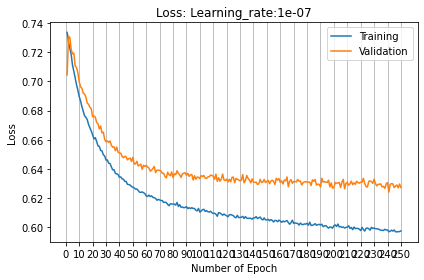

In [22]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0
dense_dropout_rate=0
# weight_decay=1e-8
weight_decay=0

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epoch)
######################################

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn


# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = loss_corn(pred, y_batch, 3, class_weights)

        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if epoch % 10 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")

## Cyclical lr

In [ ]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0.05
dense_dropout_rate=0.5
weight_decay=1e-8

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=0.001)
######################################

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = loss_corn(pred, y_batch, 3, class_weights)

        train_batch_loss.append(loss_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [19]:
def loss_corn(logits, y_train, num_classes):
    sets = []
    for i in range(num_classes-1):
        label_mask = y_train > i-1
        label_tensor = (y_train[label_mask] > i).to(torch.int64)
        sets.append((label_mask, label_tensor))

    num_examples = 0
    losses = 0.
    for task_index, s in enumerate(sets):
        train_examples = s[0]
        train_labels = s[1]

        if len(train_labels) < 1:
            continue

        num_examples += len(train_labels)
        pred = logits[train_examples, task_index]

        loss = -torch.sum(F.logsigmoid(pred)*train_labels
                          + (F.logsigmoid(pred) - pred)*(1-train_labels)
                          )
        losses += loss
    return losses/num_examples


In [20]:
pred  = torch.tensor([[0.0000, 0.5111],
        [0.1329, 1.1051]], device='cuda:0')
target = torch.tensor([0, 0], device='cuda:0')


In [22]:
out = loss_corn(pred, target, 3)
print(out)

tensor(0.7275, device='cuda:0')
